### UAS Praktikum Machine Learning
#### Disusun oleh : 
#### - William Wijaya (2172011)
#### - Fabio Michael Jovancha (2172014)
#### - Adhitya Putra P. (2172024)
#### - Nathan Joshua (2172026)

## Email Spam Detector
#### Hampir seluruh kodingan tahap Preprocessing data diambil dari : https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb bagian 4
#### Dataset diambil dari http://spamassassin.apache.org/old/publiccorpus/ dan menggunakan "20030228_easy_ham.tar.bz2" dan "20030228_spam.tar.bz2"
#### Terdapat 2 class yang digunakan yaitu EmailToWordCounterTransformer dan WordCounterToVectorTransformer
#### Model yang digunakan 4 yaitu ( Logistic Regression, SVM Regression, Random Forest Regression, AdaBoost Regression)


In [83]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [84]:
fetch_spam_data()

In [85]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [86]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [87]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [88]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [89]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [90]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [91]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [92]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [93]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [95]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [96]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


In [97]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [98]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'s': 2, 'like': 2, 'were': 2, 'ye': 1, 'it': 1, 'nice': 1, 'to': 1, 'be': 1, 'back': 1, 'in': 1, 'america': 1, 'flaccid': 1, 'state': 1, 'seem': 1, 'onli': 1, 'yesterday': 1, 'we': 1, 'suffer': 1, 'electil': 1, 'dysfunct': 1, 'mayb': 1, 'if': 1, 'they': 1, 'made': 1, 'the': 1, 'ballot': 1, 'oval': 1, 'look': 1, 'littl': 1, 'blue': 1, 'pill': 1, 'no': 1, 'serious': 1, 'i': 1, 'm': 1, 'here': 1, 'all': 1, 'week': 1, 'you': 1, 'great': 1, 'nite': 1, 'everybodi': 1}),
       Counter({'number': 9, 'the': 7, 'of': 4, 'it': 4, 'and': 3, 's': 3, 'thi': 2, 'gay': 2, 'or': 2, 'numberk': 2, 'in': 2, 'suggest': 2, 'that': 2, 'a': 2, 'rah': 2, 'who': 2, 'for': 2, 'ha': 2, 'been': 2, 'ibuc': 2, 'com': 2, 'at': 1, 'am': 1, 'on': 1, 'gordon': 1, 'mohr': 1, 'wrote': 1, 'calcul': 1, 'elid': 1, 'cours': 1, 'say': 1, 'veri': 1, 'littl': 1, 'almost': 1, 'noth': 1, 'about': 1, 'overal': 1, 'popul': 1, 'behavior': 1, 'straight': 1, 'rel': 1, 'preval': 1, 'individu': 1, 'either': 1, 'group': 1

In [126]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [127]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

### Logistic Regression Classifier

In [128]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 97.42%
Recall: 97.42%


In [129]:
from sklearn.model_selection import RandomizedSearchCV
hyperparameters = {
    "penalty": ['l1', 'l2', 'elasticnet'],
    "C" : [0.001, 0.01, 0.1],
    "solver": ['saga', 'liblinear', 'lbfgs']
}
rnd_search_cv = RandomizedSearchCV(log_clf,hyperparameters,n_iter=100,cv=5,random_state=42)
rnd_search_cv.fit(X_train_transformed, y_train)
rnd_search_cv.best_params_

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\lin

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}

In [130]:
y_pred = rnd_search_cv.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 98.05%
Recall: 97.42%


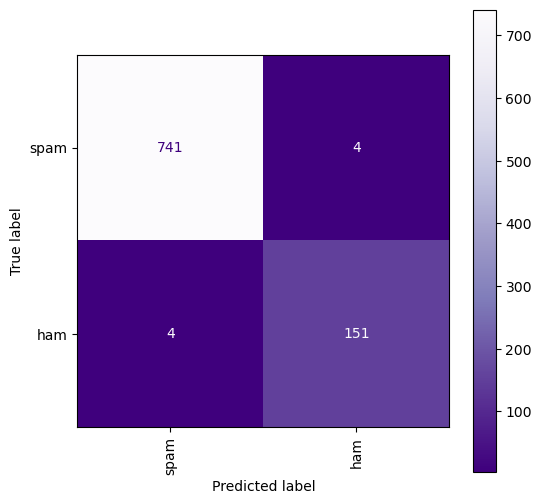

In [131]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)
cmd.from_estimator(log_clf, X_test_transformed, y_test, display_labels=['spam','ham'],
                   cmap='Purples_r', xticks_rotation='vertical', ax=ax)

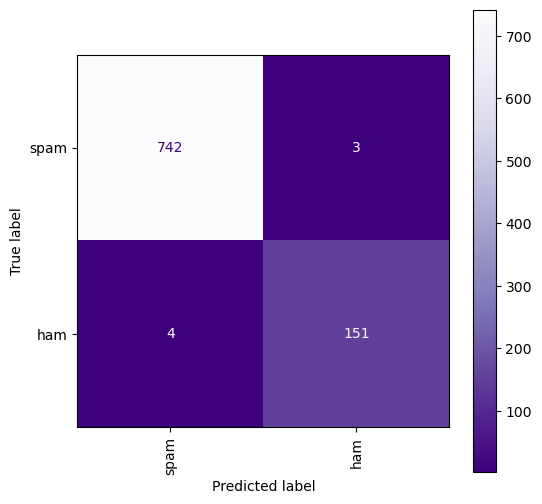

In [132]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)
cmd.from_estimator(rnd_search_cv, X_test_transformed, y_test, display_labels=['spam','ham'],
                   cmap='Purples_r', xticks_rotation='vertical', ax=ax)

### SVM Classifier

In [133]:
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(X_train_transformed, y_train)

SVC()

In [134]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(svm_clf, X_train_transformed, y_train, cv = 3)
score.mean()

y_pred = svm_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 100.00%
Recall: 19.35%


In [135]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
param_distrib = {
    "gamma": ['scale', 'auto'],
    "C" : [0.001, 0.01, 0.1],
    'kernel': ['linear', 'poly', 'rbf']
}
rnd_search_svm = RandomizedSearchCV(svm_clf,param_distrib,n_iter=100,cv=5,random_state=42)
rnd_search_svm.fit(X_train_transformed, y_train)
rnd_search_svm.best_params_

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}

In [136]:
y_pred = rnd_search_svm.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.84%
Recall: 98.71%


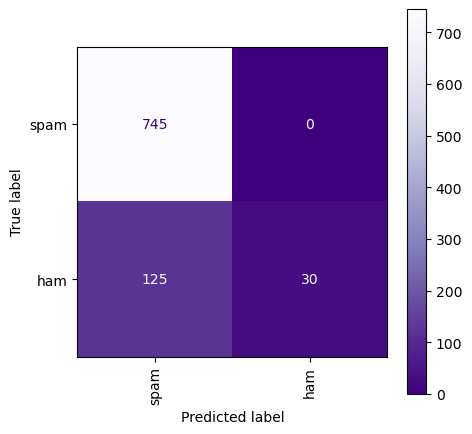

In [137]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cmd.from_estimator(svm_clf, X_test_transformed, y_test, display_labels=['spam','ham'],
                   cmap='Purples_r', xticks_rotation='vertical', ax=ax)

### setelah di tuning

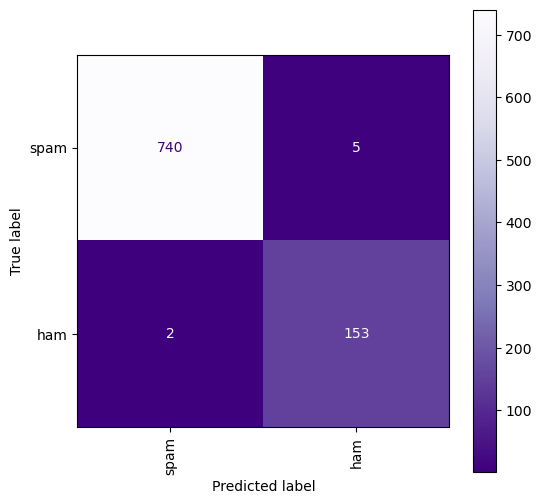

In [138]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)
cmd.from_estimator(rnd_search_svm, X_test_transformed, y_test, display_labels=['spam','ham'],
                   cmap='Purples_r', xticks_rotation='vertical', ax=ax)

### Random Forest Classifier

In [139]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators = 100)
rnd_clf.fit(X_train_transformed, y_train)
score = cross_val_score(rnd_clf, X_train_transformed, y_train, cv = 3)
score.mean()

0.98

In [140]:
y_pred = rnd_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 98.60%
Recall: 90.97%


In [141]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2']
 }
rnd_search_rnd = RandomizedSearchCV(rnd_clf,params,n_iter=100,cv=5,random_state=42)
rnd_search_rnd.fit(X_train_transformed, y_train)
rnd_search_rnd.best_params_

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.

{'max_features': 'sqrt', 'criterion': 'entropy'}

In [142]:
y_pred = rnd_search_rnd.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 99.30%
Recall: 91.61%


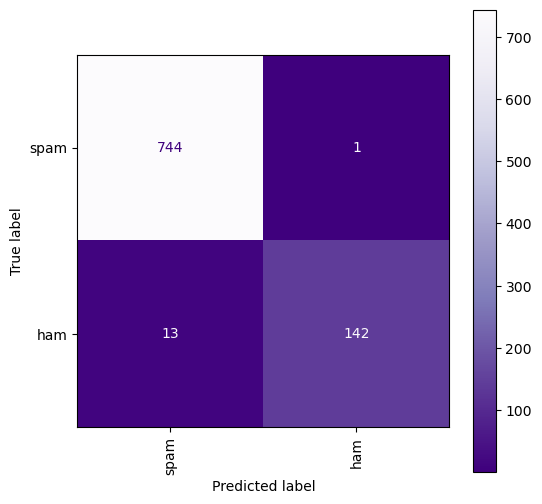

In [143]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)
cmd.from_estimator(rnd_search_rnd, X_test_transformed, y_test, display_labels=['spam','ham'],
                   cmap='Purples_r', xticks_rotation='vertical', ax=ax)

### AdaBoost Classifier

In [144]:
from sklearn.ensemble import AdaBoostClassifier
adb_clf = AdaBoostClassifier(n_estimators=100)
adb_clf.fit(X_train_transformed, y_train)
score = cross_val_score(adb_clf, X_train_transformed, y_train, cv = 3)
score.mean()

0.978095238095238

In [145]:
y_pred = adb_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.13%
Recall: 96.13%


In [146]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
params = {
    
    'n_estimators' : [25, 50, 100,],
    'algorithm' : ['SAMME', 'SAMME.R'],
    'learning_rate' : [0.0, 0.1, 1]
 }
rnd_search_adb = RandomizedSearchCV(adb_clf,params,n_iter=100,cv=5,random_state=42)
rnd_search_adb.fit(X_train_transformed, y_train)
rnd_search_adb.best_params_

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_weigh

{'n_estimators': 100, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

In [147]:
y_pred = rnd_search_adb.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.13%
Recall: 96.13%


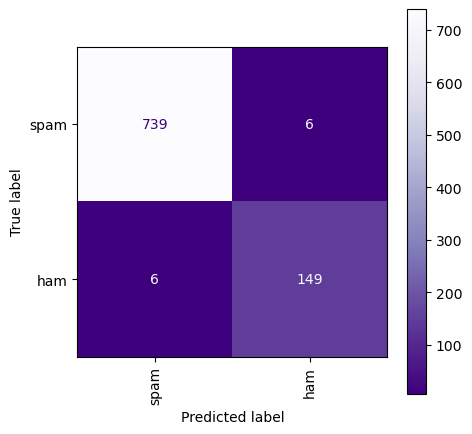

In [148]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cmd.from_estimator(adb_clf, X_test_transformed, y_test, display_labels=['spam','ham'],
                   cmap='Purples_r', xticks_rotation='vertical', ax=ax)

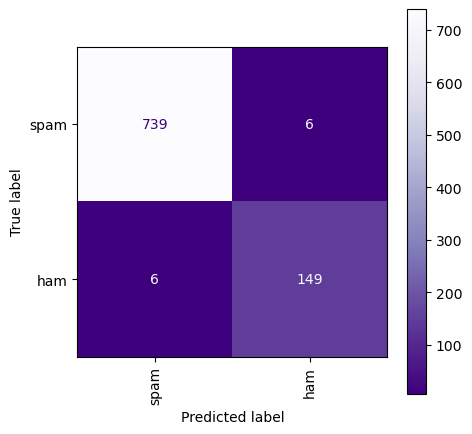

In [149]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cmd.from_estimator(rnd_search_adb, X_test_transformed, y_test, display_labels=['spam','ham'],
                   cmap='Purples_r', xticks_rotation='vertical', ax=ax)